In [1]:
import prepare_circuit as pc
import pyzx as zx
import statistics
import multiprocessing
import multiprocess as mp
# code by Y.Suzuki
from __future__ import annotations
from qiskit import QuantumCircuit, assemble
import numpy as np
import sys
def _parse_qobj_dict(qasm: str) -> dict:
    """Parse qasm to qobj_dict

    Args:
        qasm (str): qasm string
    Returns:
        dict: qobj dict
    """
    qiskit_circuit = QuantumCircuit.from_qasm_str(qasm)
    qobj = assemble(qiskit_circuit)
    qobj_dict = qobj.to_dict()
    return qobj_dict
def _check_angle(value: float) -> str:
    """Check type of rotation angle
    Args:
        value (float): rotation angle
    Returns:
        str: Any of "T", "Clifford", "Pauli", "Identity"
    """
    eps = 1e-10
    value = value % (2*np.pi)
    assert(-eps < value and value < 2*np.pi+eps)
    if abs(value - np.pi/4) < eps or abs(value - 3*np.pi/4) < eps or abs(value - 5*np.pi/4) < eps or abs(value - 7*np.pi/4) < eps:
        return "T"
    elif abs(value - 2*np.pi/4) < eps or abs(value - 6*np.pi/4) < eps:
        return "Clifford"
    elif abs(value - 4*np.pi/4) < eps:
        return "Pauli"
    elif abs(value) < eps or abs(value - 8*np.pi/4) < eps:
        return "Identity"
    else:
        return "Unknown"
def _evaluate(num_qubit: int, instructions: list) -> tuple[int, int]:
    """Retrun T-gate count and depth
    Args:
        num_qubit (int): num of qubits
        instructions (list): list of Qobj instructions
    Returns:
        tuple[int, int]: pair of T-gate count and depth
    """
    depth_counter = [0 for _ in range(num_qubit)]
    tgate_count = 0
    for inst in instructions:
        if inst["name"] in ["rz", "ry", "rz"]:
            assert(len(inst["params"]) == 1)
            assert(len(inst["qubits"]) == 1)
            angle = inst["params"][0]
            target = inst["qubits"][0]
            angle_type = _check_angle(angle)
            if angle_type == "T":
                tgate_count += 1
                depth_counter[target] += 1
            elif angle_type == "Unknown":
                print(f"Unexpected rotation angle: {inst}", file=sys.stderr)
        elif inst["name"] in ["t", "tdg"]:
            assert(len(inst["qubits"]) == 1)
            target = inst["qubits"][0]
            tgate_count += 1
            depth_counter[target] += 1
        elif inst["name"] in ["h", "s", "sdg", "x", "y", "z"]:
            continue
        elif inst["name"] in ["cz", "cx"]:
            assert(len(inst["qubits"]) == 2)
            target0 = inst["qubits"][0]
            target1 = inst["qubits"][1]
            sync_count = max(depth_counter[target0], depth_counter[target1])
            depth_counter[target0] = sync_count
            depth_counter[target1] = sync_count
        else:
            print(f"Unexpected instruction: {inst}", file=sys.stderr)
    tgate_depth = max(depth_counter)
    return tgate_count, tgate_depth
def count_tgate(qasm: str) -> tuple[int, int]:
    """count tgate from qasm string
    Args:
        qasm (str): qasm string
    Returns:
        tuple[int, int]: tgate_count and tgate_depth
    """
    qobj_dict = _parse_qobj_dict(qasm)
    num_qubit = qobj_dict["config"]["n_qubits"]
    assert(len(qobj_dict["experiments"]) == 1)
    instructions = qobj_dict["experiments"][0]["instructions"]
    tgate_count, tgate_depth = _evaluate(num_qubit, instructions)
    return tgate_count, tgate_depth

prepare-circuit version 1.0.8


n: 2, dist: 1
qubits.len(): 11


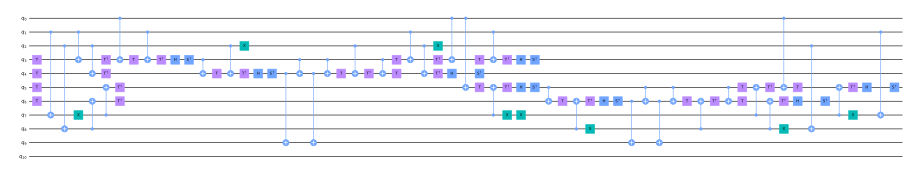

In [11]:
qasm = pc.dist_select_simple_export(2, 1)
# print(qasm)
# circuit = zx.Circuit.from_qasm(qasm)
# g = circuit.to_graph()
# zx.draw(g)
circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.draw(output="mpl", scale=0.3, fold=-1)